In [53]:
import foolbox as fb
import art
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import joblib
import matplotlib.pyplot as plt 
# import eagerpy as ep

print(tf.__version__)


2.6.3


In [54]:
X_train = joblib.load('../../preprocessed_data/CICIOT_update/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIOT_update/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIOT_update/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIOT_update/Y_test.joblib')
# print(X_train[1])
# print(Y_train[5:])

In [55]:
from keras.models import load_model

cnn_loaded = load_model('../../models/cnn_ciciot_updated_model.keras')
lstm_loaded = load_model('../../models/lstm_ciciot_updated_model.keras')
ae_lstm_loaded = load_model('../../models/ae-lstm_ciciot_updated_model.keras')



### Defining evaluation metrics functions

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import time

def evaluate(true_labels, pred_labels, title):
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, zero_division=0)
    rec = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    print(f"--- {title} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print()
    return(acc, prec, rec, f1)

## CNN

### FGSM

In [57]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.estimators.classification import KerasClassifier

# attack_fgsm = fgsmAttack(estimator=classifier)

classifier = KerasClassifier(model=cnn_loaded, clip_values=(X_test.min(), X_test.max()))
preds_clean = classifier.predict(X_test[:2000])
labels_clean = (preds_clean > 0.5).astype(int).flatten()
print(X_test.min(), X_test.max())

# only keep correctly classified traffic (TP and TN)
correct = labels_clean == Y_test[:2000]
X_correct = X_test[:2000][correct]
Y_correct = Y_test[:2000][correct]

classifier = KerasClassifier(model=cnn_loaded, clip_values=(X_correct.min(), X_correct.max()))

epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 0.8, 1.0]

/home/bossantm/anaconda3/envs/dl-attack-env/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.0 1.4


### FGSM (FastGradientMethod)

In [58]:
# fgsm predictions
fgsm_acc, fgsm_prec, fgsm_rec, fgsm_f1 = [], [], [], []
start = time.time()
for i in range(len(epsilons)):
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=epsilons[i])
    adv_fgsm = attack_fgsm.generate(x=X_correct, y=Y_correct)
    preds_adv_fgsm = classifier.predict(adv_fgsm)
    labels_adv_fgsm = (preds_adv_fgsm > 0.5).astype(int).flatten()
    (acc, prec, rec, f1) = evaluate(Y_correct, labels_adv_fgsm, f"FGSM Attack - intenisty: {epsilons[i]*100}%")
    fgsm_acc.append(acc)
    fgsm_prec.append(prec)
    fgsm_rec.append(rec)
    fgsm_f1.append(f1)
    if i == 1.0 :
        fgsm_fpr, fgsm_tpr, fgsm_thresholds = roc_curve(Y_correct, labels_adv_fgsm)
        fgsm_roc_auc = auc(fgsm_fpr, fgsm_tpr)
print(f"FGSM Time: {time.time() - start:.2f} sec\n")

--- FGSM Attack - intenisty: 1.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- FGSM Attack - intenisty: 5.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- FGSM Attack - intenisty: 10.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- FGSM Attack - intenisty: 20.0% ---
Accuracy : 0.8596
Precision: 1.0000
Recall   : 0.7239
F1-score : 0.8398

--- FGSM Attack - intenisty: 30.0% ---
Accuracy : 0.7432
Precision: 1.0000
Recall   : 0.4950
F1-score : 0.6622

--- FGSM Attack - intenisty: 60.0% ---
Accuracy : 0.4962
Precision: 0.6667
Recall   : 0.0181
F1-score : 0.0352

--- FGSM Attack - intenisty: 80.0% ---
Accuracy : 0.4880
Precision: 0.3793
Recall   : 0.0110
F1-score : 0.0215

--- FGSM Attack - intenisty: 100.0% ---
Accuracy : 0.4824
Precision: 0.2353
Recall   : 0.0080
F1-score : 0.0155

FGSM Time: 1.41 sec



### ProjectedGradientDescent

In [59]:
# ProjectedGradientDescent predictions
pgd_acc, pgd_prec, pgd_rec, pgd_f1 = [], [], [], []
start = time.time()
for i in range(len(epsilons)):
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=epsilons[i], verbose=False)
    adv_pgd = attack_pgd.generate(x=X_correct, y=Y_correct)
    preds_adv_pgd = classifier.predict(adv_pgd)
    labels_adv_pgd = (preds_adv_pgd > 0.5).astype(int).flatten()
    (acc, prec, rec, f1) = evaluate(Y_correct, labels_adv_pgd, f"PGD Attack - intenisty: {epsilons[i]*100}%")
    pgd_acc.append(acc)
    pgd_prec.append(prec)
    pgd_rec.append(rec)
    pgd_f1.append(f1)
    if i == 1.0 :
        pgd_fpr, pgd_tpr, pgd_thresholds = roc_curve(Y_correct, labels_adv_pgd)
        pgd_roc_auc = auc(pgd_fpr, pgd_tpr)
print(f"PGD Time: {time.time() - start:.2f} sec\n")

--- PGD Attack - intenisty: 1.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 5.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 10.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 20.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 30.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 60.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 80.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 100.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

PGD Time: 66.25 sec



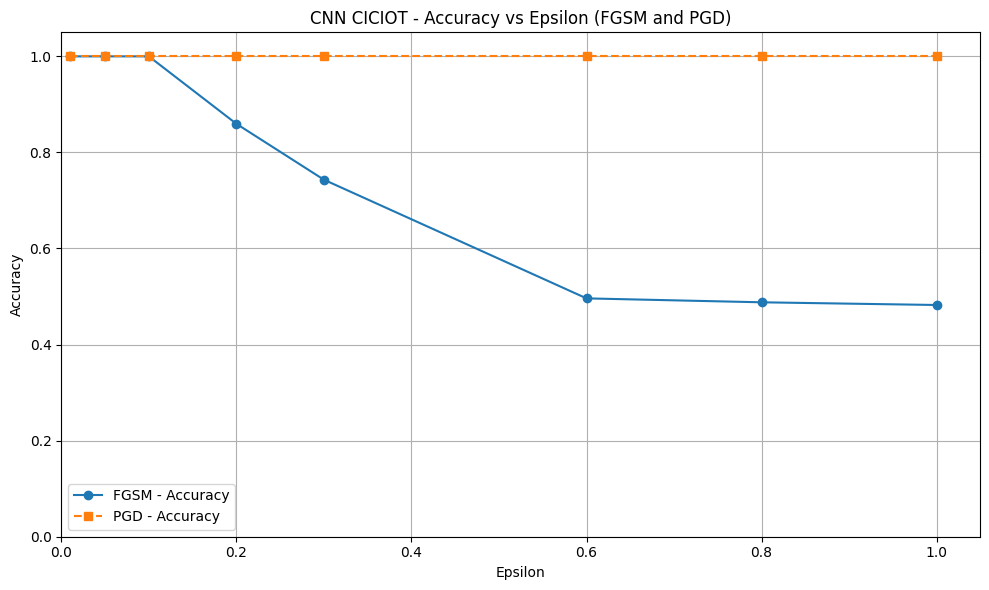

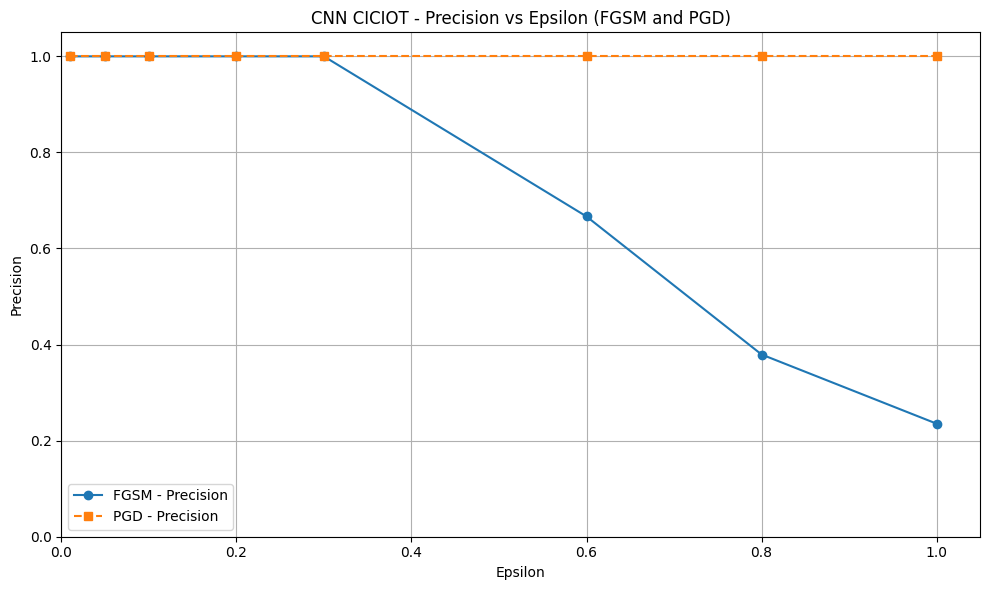

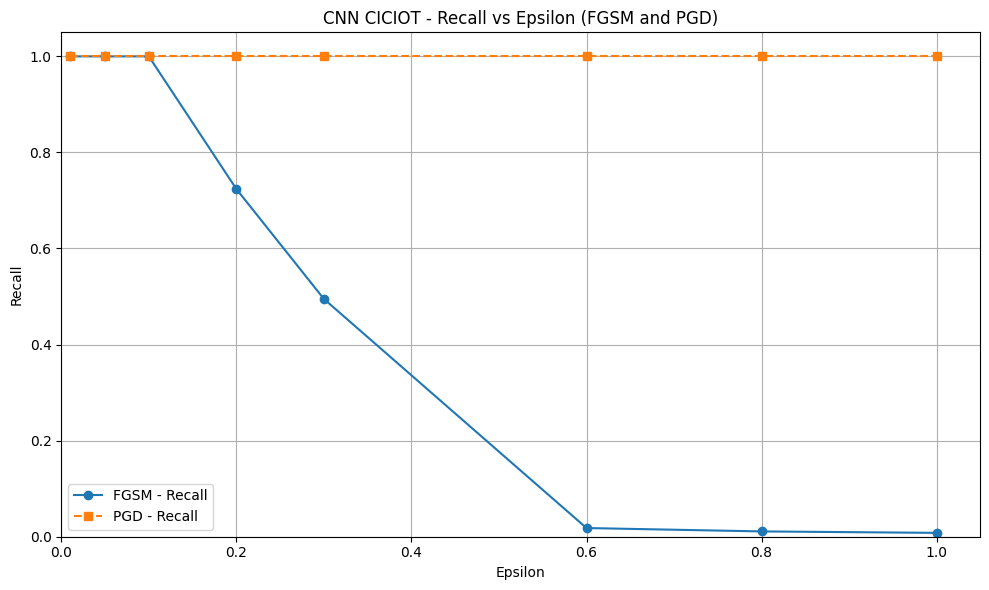

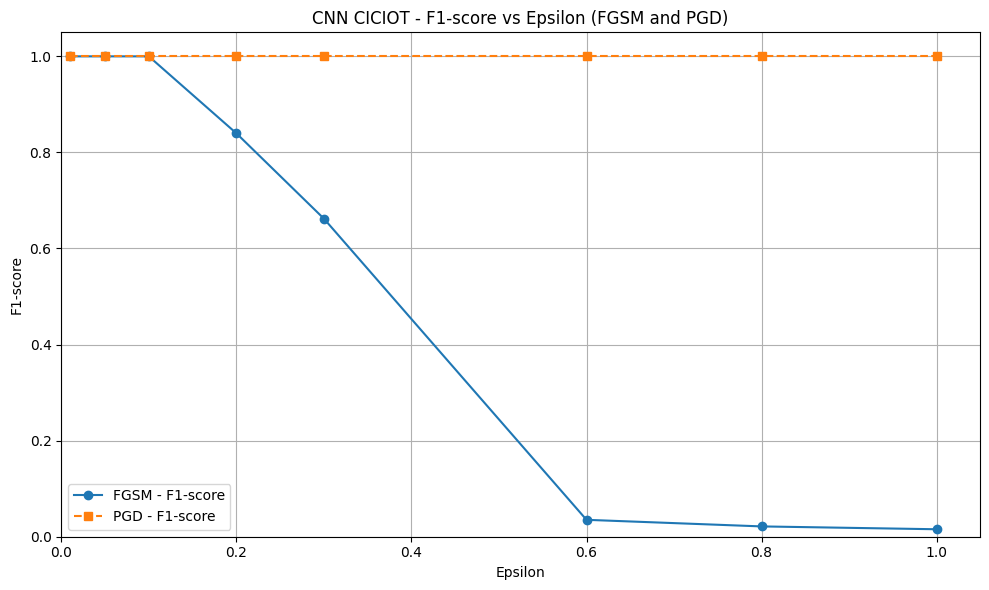

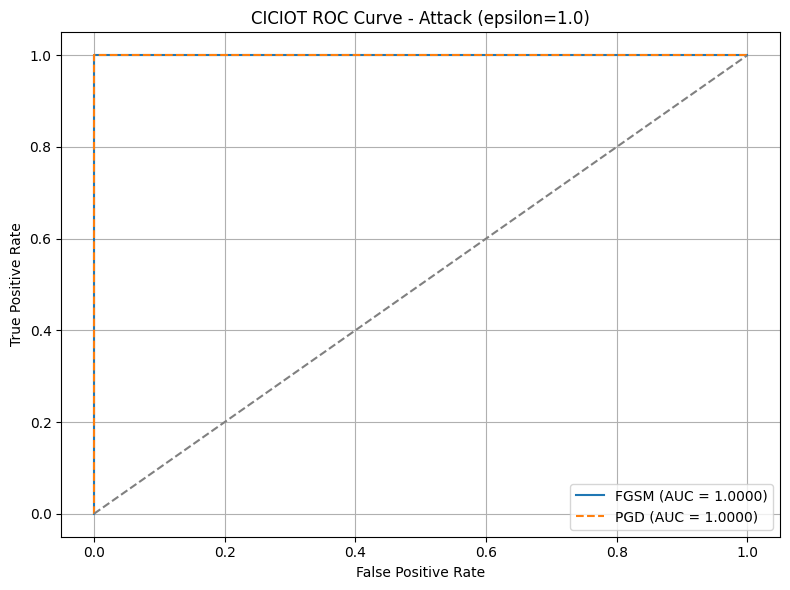

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epsilons, fgsm_acc, label='FGSM - Accuracy', marker='o', linestyle='-', color='tab:blue')
plt.plot(epsilons, pgd_acc, label='PGD - Accuracy', marker='s', linestyle='--', color='tab:orange')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('CNN CICIOT - Accuracy vs Epsilon (FGSM and PGD)')
plt.xlim(left=0.0)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../../results/attack/CICIOT_accuracy_CNN.png', dpi=1000)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilons, fgsm_prec, label='FGSM - Precision', marker='o', linestyle='-', color='tab:blue')
plt.plot(epsilons, pgd_prec, label='PGD - Precision', marker='s', linestyle='--', color='tab:orange')
plt.xlabel('Epsilon')
plt.ylabel('Precision')
plt.title('CNN CICIOT - Precision vs Epsilon (FGSM and PGD)')
plt.xlim(left=0.0)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../../results/attack/CICIOT_precision_CNN.png', dpi=1000)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilons, fgsm_rec, label='FGSM - Recall', marker='o', linestyle='-', color='tab:blue')
plt.plot(epsilons, pgd_rec, label='PGD - Recall', marker='s', linestyle='--', color='tab:orange')
plt.xlabel('Epsilon')
plt.ylabel('Recall')
plt.title('CNN CICIOT - Recall vs Epsilon (FGSM and PGD)')
plt.xlim(left=0.0)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../../results/attack/CICIOT_recall_CNN.png', dpi=1000)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilons, fgsm_f1, label='FGSM - F1-score', marker='o', linestyle='-', color='tab:blue')
plt.plot(epsilons, pgd_f1, label='PGD - F1-score', marker='s', linestyle='--', color='tab:orange')
plt.xlabel('Epsilon')
plt.ylabel('F1-score')
plt.title('CNN CICIOT - F1-score vs Epsilon (FGSM and PGD)')
plt.xlim(left=0.0)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../../results/attack/CICIOT_f1_score_CNN.png', dpi=1000)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fgsm_fpr, fgsm_tpr, label=f'FGSM (AUC = {fgsm_roc_auc:.4f})', color='tab:blue')
plt.plot(pgd_fpr, pgd_tpr, label=f'PGD (AUC = {pgd_roc_auc:.4f})', linestyle='--', color='tab:orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CICIOT ROC Curve - Attack (epsilon=1.0)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('../../results/attack/CICIOT_ROC_CNN_eps1.0.png', dpi=1000)
plt.show()

### Trying Foolbox

In [61]:
fmodel = fb.TensorFlowModel(cnn_loaded, bounds=(X_test.min(), X_test.max()))

# attack = fb.attacks.HopSkipJumpAttack()
attack = fb.attacks.BoundaryAttack()
# attack = fb.attacks.FGSM()


epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 0.8, 1.0]
x = tf.constant(X_test[:5].astype(np.float32))
y = tf.constant(Y_test[:5].astype(np.int64))

advs, clipped, success = attack(fmodel, x, y, epsilons=epsilons)

for i, eps in enumerate(epsilons):
    print(f"Epsilon {eps:.2f} — Success rate: {np.mean(success[i]):.2%}")


ValueError: TensorFlowModel requires TensorFlow Eager Mode